In [ ]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [32]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
homogenous_results = np.load(os.path.expanduser('~/data/surround/2017_10_27_diversity_homogenous_results.npy'))
random_results = np.load(os.path.expanduser('~/data/surround/2017_10_27_diversity_random_results.npy'))

In [29]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

In [33]:
len(random_results)

10

In [34]:
random_results[0].keys()

dict_keys(['hw', 'cw', 'snr', 'snr_reg', 'input', 'labels', 'output', 'kernel', 'decoder', 'input_noise', 'output_noise', 'errors', 'mean_errors', 'sem_errors', 'channels'])

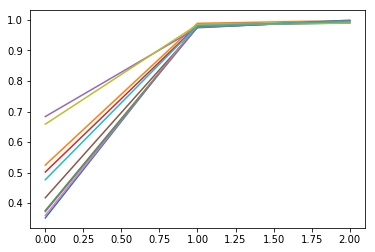

In [35]:
plt.plot(np.stack(random_results[-1]['hw']))

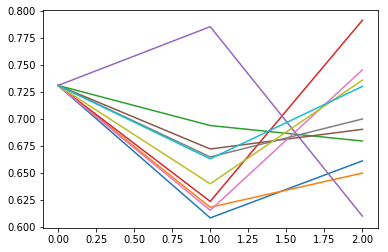

In [37]:
plt.plot(np.stack(random_results[-1]['cw']))

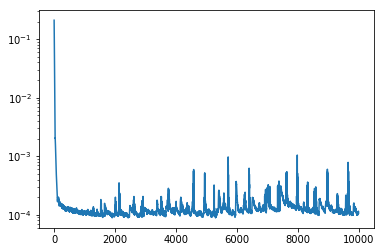

In [40]:
plt.plot(random_results[-1]['errors'])
plt.yscale('log')

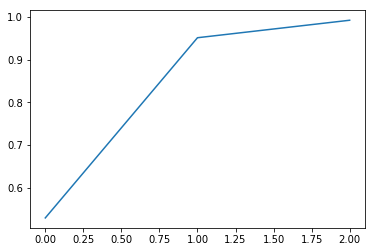

In [43]:
plt.plot(np.stack(homogenous_results[-1]['hw']))

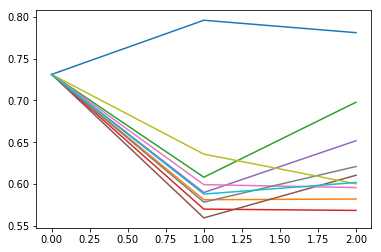

In [44]:
plt.plot(np.stack(homogenous_results[-1]['cw']))

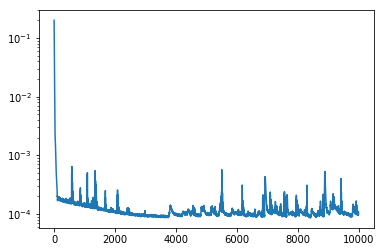

In [41]:
plt.plot(homogenous_results[-1]['errors'])
plt.yscale('log')